# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 1- Data Preparation

In [6]:
data_hosp_rate = pd.read_csv(f'../output/measures/measure_hosp_rate_binary.csv')
data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_binary.csv') 
data_hosp_rate_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_age_cat_binary.csv')
data_hosp_rate_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat.csv')
data_hosp_rate_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_gp.csv')

,sex,admitted_binary,population,value,date
0,F,307.0,510,0.601961,2019-01-01
1,M,293.0,490,0.597959,2019-01-01
2,F,289.0,497,0.581489,2019-02-01
3,M,311.0,503,0.618290,2019-02-01
4,F,293.0,502,0.583665,2019-03-01


In [8]:
# translate sex in data_hosp_rate_sex_age_cat
dict_sex = {'F': 'Female', 'M': 'Male'}
data_hosp_rate_sex = data_hosp_rate_sex.replace({"sex": dict_sex})

In [9]:
data_hosp_rate.describe(include='all')

,admitted_binary,population,value,date
count,38000.000000,38000.0,38000.000000,38000
unique,NaN,NaN,NaN,38
top,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,1000
mean,0.600000,1.0,0.600000,NaN
std,0.489904,0.0,0.489904,NaN
min,0.000000,1.0,0.000000,NaN
25%,0.000000,1.0,0.000000,NaN
50%,1.000000,1.0,1.000000,NaN
75%,1.000000,1.0,1.000000,NaN


In [10]:
data_hosp_rate_sex.describe(include='all')

,sex,admitted_binary,population,value,date
count,76,76.00000,76.000000,76.000000,76
unique,2,NaN,NaN,NaN,38
top,Female,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,2
mean,NaN,300.00000,500.000000,0.599992,NaN
std,NaN,13.48184,17.846755,0.016104,NaN
min,NaN,274.00000,466.000000,0.563707,NaN
25%,NaN,289.75000,487.000000,0.587748,NaN
50%,NaN,300.00000,500.000000,0.600000,NaN
75%,NaN,310.25000,513.000000,0.612440,NaN


In [11]:
data_hosp_rate_age_cat.describe(include='all')

,age_cat,admitted_binary,population,value,date
count,190,190.00000,190.000000,190.000000,190
unique,5,NaN,NaN,NaN,38
top,0-14,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,5
mean,NaN,120.00000,200.000000,0.600016,NaN
std,NaN,26.78861,43.560333,0.032140,NaN
min,NaN,46.00000,92.000000,0.464646,NaN
25%,NaN,119.00000,199.250000,0.577607,NaN
50%,NaN,130.00000,216.000000,0.600429,NaN
75%,NaN,137.00000,228.000000,0.623256,NaN


In [12]:
data_hosp_rate_cat.describe(include='all')

,admitted_cat,admitted_binary,population,value,date
count,418,456.000000,456.000000,456.000000,456
unique,11,NaN,NaN,NaN,38
top,A39,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,12
mean,NaN,50.000000,83.333333,0.602055,NaN
std,NaN,111.619704,186.275510,0.093829,NaN
min,NaN,4.000000,8.000000,0.266667,NaN
25%,NaN,13.000000,24.000000,0.538462,NaN
50%,NaN,17.000000,29.000000,0.598571,NaN
75%,NaN,21.000000,34.000000,0.653846,NaN


In [13]:
data_hosp_rate_gp.describe(include='all')

,gp_cons_admitted_binary,admitted_binary,population,value,date
count,76.000000,76.000000,76.0,76.000000,76
unique,NaN,NaN,NaN,NaN,38
top,NaN,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,NaN,2
mean,0.500000,300.000000,500.0,0.600000,NaN
std,0.503322,7.264526,0.0,0.014529,NaN
min,0.000000,283.000000,500.0,0.566000,NaN
25%,0.000000,296.750000,500.0,0.593500,NaN
50%,0.500000,300.000000,500.0,0.600000,NaN
75%,1.000000,303.250000,500.0,0.606500,NaN


## 2- Hospital admission rate

In [14]:
data_hosp_rate.head()

,admitted_binary,population,value,date
0,0.0,1,0.0,2019-01-01
1,1.0,1,1.0,2019-01-01
2,0.0,1,0.0,2019-01-01
3,0.0,1,0.0,2019-01-01
4,1.0,1,1.0,2019-01-01


In [16]:
data_hosp_rate_groupby_date = data_hosp_rate.groupby([data_hosp_rate['date']]).mean().reset_index()
data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01-01,0.6,1.0,0.6
1,2019-02-01,0.6,1.0,0.6
2,2019-03-01,0.6,1.0,0.6
3,2019-04-01,0.6,1.0,0.6
4,2019-05-01,0.6,1.0,0.6


In [17]:
# # data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date.index

data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date']).dt.to_period('m')
data_hosp_rate_groupby_date['date']= data_hosp_rate_groupby_date['date'].astype(str)
data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,0.6,1.0,0.6
1,2019-02,0.6,1.0,0.6
2,2019-03,0.6,1.0,0.6
3,2019-04,0.6,1.0,0.6
4,2019-05,0.6,1.0,0.6


In [19]:
data_hosp_rate_groupby_date['value'] = data_hosp_rate_groupby_date['value']*1000

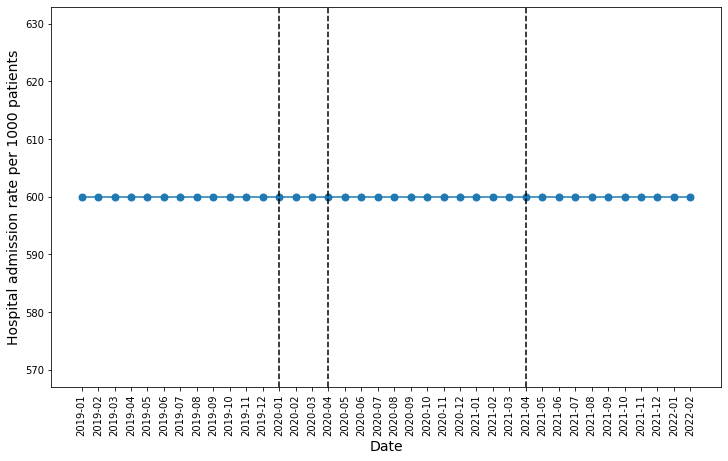

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# sns.lineplot(y=data_hosp_rate_groupby_date['value'], x=data_hosp_rate_groupby_date.index, ax=ax1, linestyle='-', marker='o', markersize=7)

ax1.plot(data_hosp_rate_groupby_date['date'], data_hosp_rate_groupby_date['value'], linestyle='-', marker='o', markersize=7)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

## 3- Hospital admission with sex

In [21]:
data_hosp_rate_sex

,sex,admitted_binary,population,value,date
0,Female,307.0,510,0.601961,2019-01-01
1,Male,293.0,490,0.597959,2019-01-01
2,Female,289.0,497,0.581489,2019-02-01
3,Male,311.0,503,0.618290,2019-02-01
4,Female,293.0,502,0.583665,2019-03-01
...,...,...,...,...,...
71,Male,284.0,470,0.604255,2021-12-01
72,Female,303.0,517,0.586074,2022-01-01
73,Male,297.0,483,0.614907,2022-01-01
74,Female,287.0,503,0.570577,2022-02-01


In [22]:
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_sex.groupby(['date', 'sex']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_cat_sex_groupby_sex.reset_index()
data_hosp_rate_cat_sex_groupby_sex.columns = ['date', 'sex', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01-01,Female,0.601961,0.601961,0.601961,0.601961
1,2019-01-01,Male,0.597959,0.597959,0.597959,0.597959
2,2019-02-01,Female,0.581489,0.581489,0.581489,0.581489
3,2019-02-01,Male,0.618290,0.618290,0.618290,0.618290
4,2019-03-01,Female,0.583665,0.583665,0.583665,0.583665


In [23]:
data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.to_period('m')
data_hosp_rate_cat_sex_groupby_sex['date']= data_hosp_rate_cat_sex_groupby_sex['date'].astype(str)
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01,Female,0.601961,0.601961,0.601961,0.601961
1,2019-01,Male,0.597959,0.597959,0.597959,0.597959
2,2019-02,Female,0.581489,0.581489,0.581489,0.581489
3,2019-02,Male,0.618290,0.618290,0.618290,0.618290
4,2019-03,Female,0.583665,0.583665,0.583665,0.583665


In [24]:
data_hosp_rate_cat_sex_groupby_sex['value_mean'] = data_hosp_rate_cat_sex_groupby_sex['value_mean']*1000

In [31]:
data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date'])
data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')
data_hosp_rate_cat_sex_groupby_sex['date']

0     2019-01
1     2019-01
2     2019-02
3     2019-02
4     2019-03
       ...   
71    2021-12
72    2022-01
73    2022-01
74    2022-02
75    2022-02
Name: date, Length: 76, dtype: object

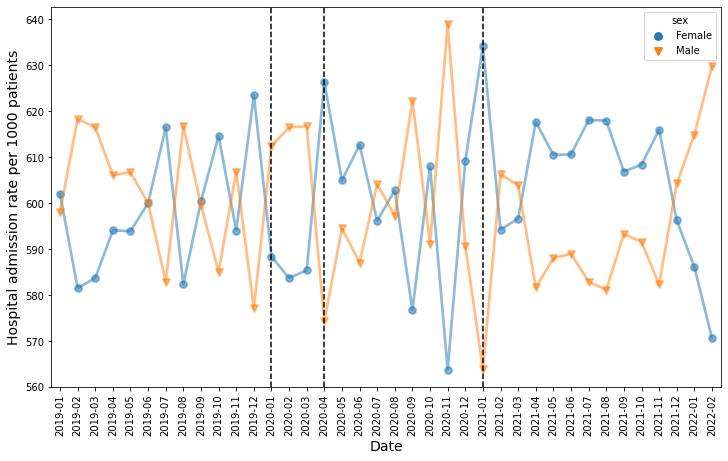

In [32]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
plt.show()

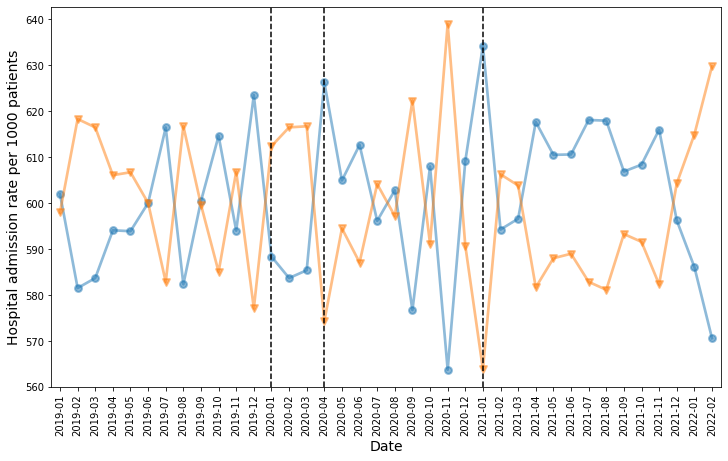

In [33]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission with age_cat

In [34]:
data_hosp_rate_age_cat

,age_cat,admitted_binary,population,value,date
0,0-14,71.0,123,0.577236,2019-01-01
1,15-34,124.0,205,0.604878,2019-01-01
2,35-54,127.0,219,0.579909,2019-01-01
3,55-74,128.0,220,0.581818,2019-01-01
4,75+,150.0,233,0.643777,2019-01-01
...,...,...,...,...,...
185,0-14,73.0,123,0.593496,2022-02-01
186,15-34,148.0,225,0.657778,2022-02-01
187,35-54,133.0,212,0.627358,2022-02-01
188,55-74,107.0,206,0.519417,2022-02-01


In [35]:
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != 0]
data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != '0']
data_hosp_rate_age_cat

,age_cat,admitted_binary,population,value,date
0,0-14,71.0,123,0.577236,2019-01-01
1,15-34,124.0,205,0.604878,2019-01-01
2,35-54,127.0,219,0.579909,2019-01-01
3,55-74,128.0,220,0.581818,2019-01-01
4,75+,150.0,233,0.643777,2019-01-01
...,...,...,...,...,...
185,0-14,73.0,123,0.593496,2022-02-01
186,15-34,148.0,225,0.657778,2022-02-01
187,35-54,133.0,212,0.627358,2022-02-01
188,55-74,107.0,206,0.519417,2022-02-01


In [36]:
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_age_cat.groupby(['date', 'age_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_cat_age_cat_groupby_age.reset_index()
data_hosp_rate_cat_age_cat_groupby_age.columns = ['date', 'age', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01-01,0-14,0.577236,0.577236,0.577236,0.577236
1,2019-01-01,15-34,0.604878,0.604878,0.604878,0.604878
2,2019-01-01,35-54,0.579909,0.579909,0.579909,0.579909
3,2019-01-01,55-74,0.581818,0.581818,0.581818,0.581818
4,2019-01-01,75+,0.643777,0.643777,0.643777,0.643777


In [37]:
data_hosp_rate_cat_age_cat_groupby_age.date = pd.to_datetime(data_hosp_rate_cat_age_cat_groupby_age.date)

data_hosp_rate_cat_age_cat_groupby_age.date = data_hosp_rate_cat_age_cat_groupby_age.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01,0-14,0.577236,0.577236,0.577236,0.577236
1,2019-01,15-34,0.604878,0.604878,0.604878,0.604878
2,2019-01,35-54,0.579909,0.579909,0.579909,0.579909
3,2019-01,55-74,0.581818,0.581818,0.581818,0.581818
4,2019-01,75+,0.643777,0.643777,0.643777,0.643777


In [38]:
data_hosp_rate_cat_age_cat_groupby_age['value_mean'] = data_hosp_rate_cat_age_cat_groupby_age['value_mean']*1000

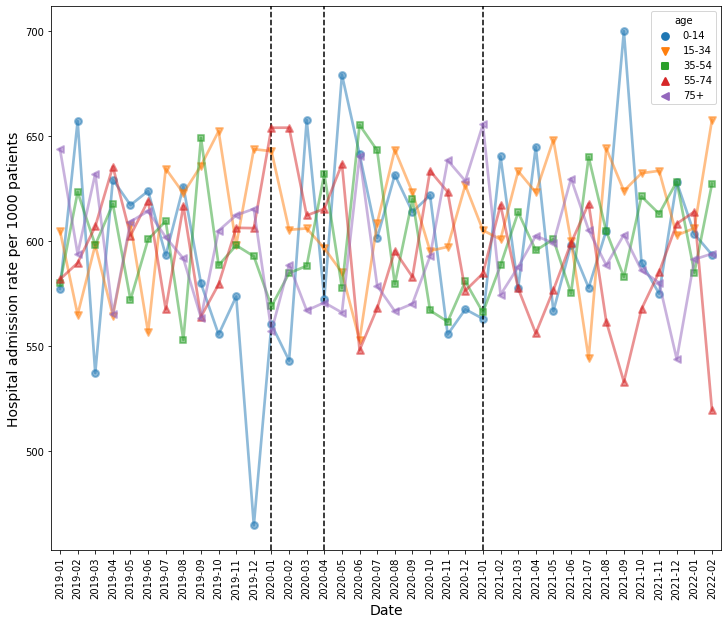

In [39]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient.jpg')
plt.show()

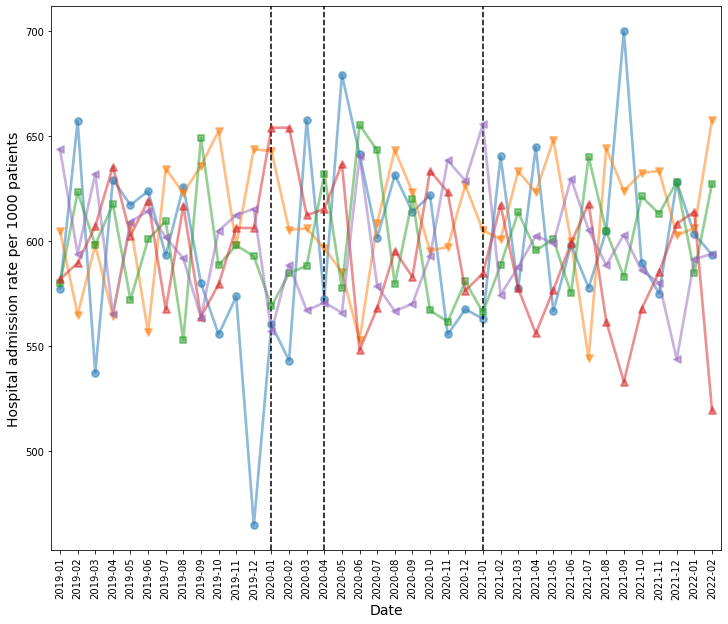

In [40]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient_nolegend.jpg')
plt.show()

## 5- Hospital admission with admission category

In [41]:
print(f'shape of data_hosp_rate_cat: {data_hosp_rate_cat.shape}\n')
data_hosp_rate_cat

shape of data_hosp_rate_cat: (456, 5)



,admitted_cat,admitted_binary,population,value,date
0,NaN,419.0,700,0.598571,2019-01-01
1,A39,20.0,35,0.571429,2019-01-01
2,A40,20.0,32,0.625000,2019-01-01
3,A41,15.0,23,0.652174,2019-01-01
4,B95,4.0,15,0.266667,2019-01-01
...,...,...,...,...,...
451,J13,23.0,29,0.793103,2022-02-01
452,K05,17.0,27,0.629630,2022-02-01
453,L01,19.0,30,0.633333,2022-02-01
454,M00,29.0,32,0.906250,2022-02-01


In [42]:
data_hosp_rate_sex_groupby_date = data_hosp_rate_sex.groupby([data_hosp_rate_sex['date']]).sum().reset_index()
data_hosp_rate_sex_groupby_date['date'] = pd.to_datetime(data_hosp_rate_sex_groupby_date['date']).dt.to_period('m')
data_hosp_rate_sex_groupby_date['date']= data_hosp_rate_sex_groupby_date['date'].astype(str)
data_hosp_rate_sex_groupby_date#.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199920
1,2019-02,600.0,1000,1.199779
2,2019-03,600.0,1000,1.200131
3,2019-04,600.0,1000,1.200120
4,2019-05,600.0,1000,1.200564
5,2019-06,600.0,1000,1.200000
6,2019-07,600.0,1000,1.199260
7,2019-08,600.0,1000,1.199036
8,2019-09,600.0,1000,1.200027
9,2019-10,600.0,1000,1.199645


In [43]:
data_hosp_rate_cat = data_hosp_rate_cat.replace(np.nan, 'NA', regex=True)
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
0,NA,419.0,700,0.598571,2019-01-01
1,A39,20.0,35,0.571429,2019-01-01
2,A40,20.0,32,0.625000,2019-01-01
3,A41,15.0,23,0.652174,2019-01-01
4,B95,4.0,15,0.266667,2019-01-01
...,...,...,...,...,...
451,J13,23.0,29,0.793103,2022-02-01
452,K05,17.0,27,0.629630,2022-02-01
453,L01,19.0,30,0.633333,2022-02-01
454,M00,29.0,32,0.906250,2022-02-01


In [44]:
data_hosp_rate_cat[data_hosp_rate_cat['admitted_cat']=='NA'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value']]

,date,admitted_cat,admitted_binary,population,value
0,2019-01-01,NA,419.0,700,0.598571
12,2019-02-01,NA,419.0,700,0.598571
24,2019-03-01,NA,417.0,700,0.595714
36,2019-04-01,NA,415.0,700,0.592857
48,2019-05-01,NA,426.0,700,0.608571
60,2019-06-01,NA,412.0,700,0.588571
72,2019-07-01,NA,415.0,700,0.592857
84,2019-08-01,NA,413.0,700,0.590000
96,2019-09-01,NA,411.0,700,0.587143
108,2019-10-01,NA,417.0,700,0.595714


In [45]:
data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat.admitted_cat != 'NA']
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A39,20.0,35,0.571429,2019-01-01
2,A40,20.0,32,0.625000,2019-01-01
3,A41,15.0,23,0.652174,2019-01-01
4,B95,4.0,15,0.266667,2019-01-01
5,G00,16.0,21,0.761905,2019-01-01
...,...,...,...,...,...
451,J13,23.0,29,0.793103,2022-02-01
452,K05,17.0,27,0.629630,2022-02-01
453,L01,19.0,30,0.633333,2022-02-01
454,M00,29.0,32,0.906250,2022-02-01


In [46]:
# data_hosp_rate_cat[data_hosp_rate_cat["admitted_cat"].str.contains("A40")]
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A40'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A41'), 'admitted_cat'] = 'Sepsis'
# data_hosp_rate_cat.loc[((data_hosp_rate_cat['admitted_cat'].str.contains('A40')) & (data_hosp_rate_cat['admitted_cat'].str.contains('A41'))), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N39'), 'admitted_cat'] = 'UTI-related'
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A39,20.0,35,0.571429,2019-01-01
2,Sepsis,20.0,32,0.625000,2019-01-01
3,Sepsis,15.0,23,0.652174,2019-01-01
4,B95,4.0,15,0.266667,2019-01-01
5,G00,16.0,21,0.761905,2019-01-01
...,...,...,...,...,...
451,J13,23.0,29,0.793103,2022-02-01
452,K05,17.0,27,0.629630,2022-02-01
453,L01,19.0,30,0.633333,2022-02-01
454,M00,29.0,32,0.906250,2022-02-01


In [47]:
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A'), 'admitted_cat'] = 'A'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('B'), 'admitted_cat'] = 'B'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('G'), 'admitted_cat'] = 'G'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('H'), 'admitted_cat'] = 'H'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('J'), 'admitted_cat'] = 'J'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('K'), 'admitted_cat'] = 'K'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('L'), 'admitted_cat'] = 'L'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('M'), 'admitted_cat'] = 'M'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N'), 'admitted_cat'] = 'N'

data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A,20.0,35,0.571429,2019-01-01
2,Sepsis,20.0,32,0.625000,2019-01-01
3,Sepsis,15.0,23,0.652174,2019-01-01
4,B,4.0,15,0.266667,2019-01-01
5,G,16.0,21,0.761905,2019-01-01
...,...,...,...,...,...
451,J,23.0,29,0.793103,2022-02-01
452,K,17.0,27,0.629630,2022-02-01
453,L,19.0,30,0.633333,2022-02-01
454,M,29.0,32,0.906250,2022-02-01


In [48]:
data_hosp_rate_cat.date = pd.to_datetime(data_hosp_rate_cat.date)

data_hosp_rate_cat.date = data_hosp_rate_cat.date.dt.strftime('%Y-%m')

data_hosp_rate_cat#.head()

,admitted_cat,admitted_binary,population,value,date
1,A,20.0,35,0.571429,2019-01
2,Sepsis,20.0,32,0.625000,2019-01
3,Sepsis,15.0,23,0.652174,2019-01
4,B,4.0,15,0.266667,2019-01
5,G,16.0,21,0.761905,2019-01
...,...,...,...,...,...
451,J,23.0,29,0.793103,2022-02
452,K,17.0,27,0.629630,2022-02
453,L,19.0,30,0.633333,2022-02
454,M,29.0,32,0.906250,2022-02


In [49]:
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat.groupby(['date', 'admitted_cat'], as_index=False).sum()
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value
0,2019-01,A,20.0,35,0.571429
1,2019-01,B,4.0,15,0.266667
2,2019-01,G,16.0,21,0.761905
3,2019-01,H,12.0,23,0.521739
4,2019-01,J,17.0,33,0.515152
...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630
376,2022-02,L,19.0,30,0.633333
377,2022-02,M,29.0,32,0.906250
378,2022-02,N,18.0,30,0.600000


In [50]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value']]

,date,admitted_cat,admitted_binary,population,value
0,2019-01,A,20.0,35,0.571429
1,2019-01,B,4.0,15,0.266667
2,2019-01,G,16.0,21,0.761905
3,2019-01,H,12.0,23,0.521739
4,2019-01,J,17.0,33,0.515152
5,2019-01,K,21.0,30,0.700000
6,2019-01,L,23.0,31,0.741935
7,2019-01,M,17.0,31,0.548387
8,2019-01,N,16.0,26,0.615385
9,2019-01,Sepsis,35.0,55,1.277174


In [51]:
data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary_sum'] = data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary'].groupby(data_hosp_rate_cat_groupby_date_admitted_cat['date']).transform('sum')
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum
0,2019-01,A,20.0,35,0.571429,181.0
1,2019-01,B,4.0,15,0.266667,181.0
2,2019-01,G,16.0,21,0.761905,181.0
3,2019-01,H,12.0,23,0.521739,181.0
4,2019-01,J,17.0,33,0.515152,181.0
...,...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630,201.0
376,2022-02,L,19.0,30,0.633333,201.0
377,2022-02,M,29.0,32,0.906250,201.0
378,2022-02,N,18.0,30,0.600000,201.0


In [52]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = (data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary']/data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary_sum'])*100
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,20.0,35,0.571429,181.0,11.049724
1,2019-01,B,4.0,15,0.266667,181.0,2.209945
2,2019-01,G,16.0,21,0.761905,181.0,8.839779
3,2019-01,H,12.0,23,0.521739,181.0,6.629834
4,2019-01,J,17.0,33,0.515152,181.0,9.392265
...,...,...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630,201.0,8.457711
376,2022-02,L,19.0,30,0.633333,201.0,9.452736
377,2022-02,M,29.0,32,0.906250,201.0,14.427861
378,2022-02,N,18.0,30,0.600000,201.0,8.955224


In [53]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value', 'admitted_binary_sum', 'value_calculated']]

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,20.0,35,0.571429,181.0,11.049724
1,2019-01,B,4.0,15,0.266667,181.0,2.209945
2,2019-01,G,16.0,21,0.761905,181.0,8.839779
3,2019-01,H,12.0,23,0.521739,181.0,6.629834
4,2019-01,J,17.0,33,0.515152,181.0,9.392265
5,2019-01,K,21.0,30,0.700000,181.0,11.602210
6,2019-01,L,23.0,31,0.741935,181.0,12.707182
7,2019-01,M,17.0,31,0.548387,181.0,9.392265
8,2019-01,N,16.0,26,0.615385,181.0,8.839779
9,2019-01,Sepsis,35.0,55,1.277174,181.0,19.337017


In [54]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value', 'admitted_binary_sum', 'value_calculated']].value_calculated.sum()

100.0

In [55]:
# data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated']*1000
# data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii']*1000

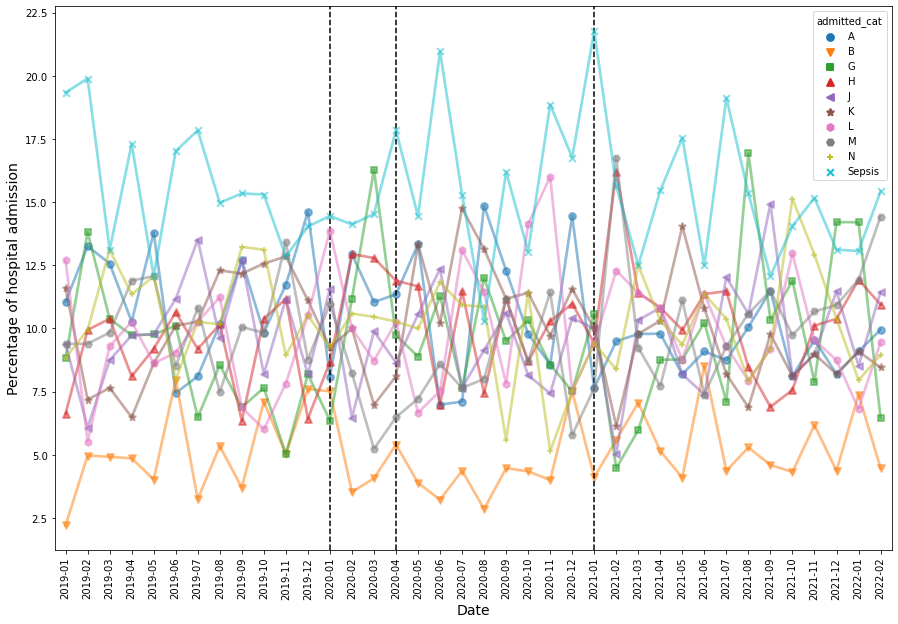

In [56]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_cat.jpg')
plt.show()

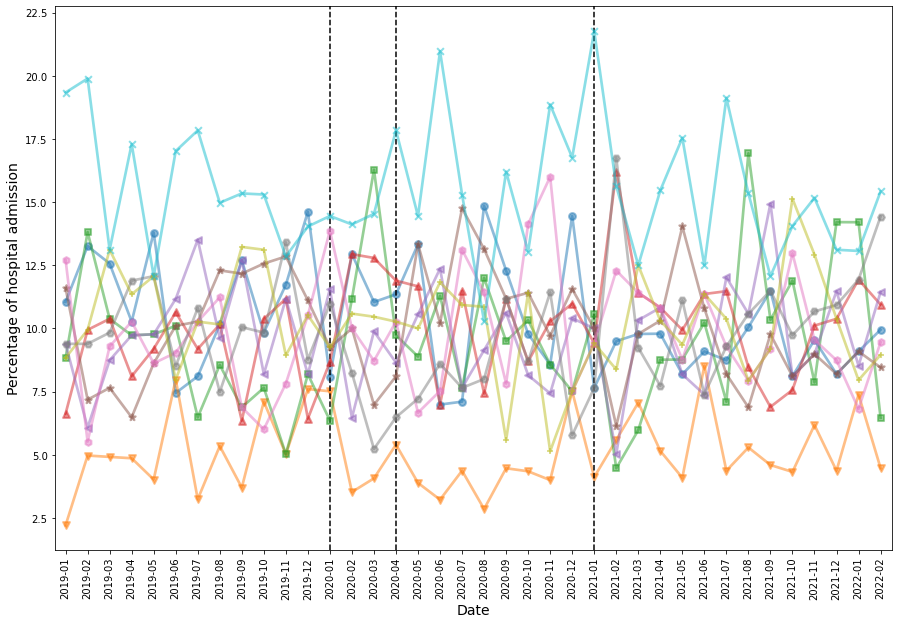

In [57]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_cat_nolegend.jpg')
plt.show()

In [84]:
data_hosp_rate_cat_groupby_date_admitted_cat.head()

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,20.0,35,0.571429,181.0,0.110497
1,2019-01,B,4.0,15,0.266667,181.0,0.022099
2,2019-01,G,16.0,21,0.761905,181.0,0.088398
3,2019-01,H,12.0,23,0.521739,181.0,0.066298
4,2019-01,J,17.0,33,0.515152,181.0,0.093923


In [83]:
data_hosp_rate_sex_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199920
1,2019-02,600.0,1000,1.199779
2,2019-03,600.0,1000,1.200131
3,2019-04,600.0,1000,1.200120
4,2019-05,600.0,1000,1.200564


In [93]:
#add population_group_by_sex to calculate rate of hospital admission with hosp cat
data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex'] = np.nan
col_population = data_hosp_rate_cat_groupby_date_admitted_cat.columns.get_loc('population_group_by_sex')
col_date = data_hosp_rate_cat_groupby_date_admitted_cat.columns.get_loc('date')
col_population_sex_groupby_date = data_hosp_rate_sex_groupby_date.columns.get_loc('population')
col_date_sex_groupby = data_hosp_rate_sex_groupby_date.columns.get_loc('date')

for idx, x in enumerate(data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex']):
    for idy, y in enumerate(data_hosp_rate_sex_groupby_date['population']):
        if data_hosp_rate_sex_groupby_date.iat[idy, col_date_sex_groupby] == data_hosp_rate_cat_groupby_date_admitted_cat.iat[idx, col_date]:
            data_hosp_rate_cat_groupby_date_admitted_cat.iat[idx, col_population] = data_hosp_rate_sex_groupby_date.iat[idy, col_population_sex_groupby_date]

data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated,population_group_by_sex,value_calculated_ii
0,2019-01,A,20.0,35,0.571429,181.0,0.110497,1000.0,33.333333
1,2019-01,B,4.0,15,0.266667,181.0,0.022099,1000.0,6.666667
2,2019-01,G,16.0,21,0.761905,181.0,0.088398,1000.0,26.666667
3,2019-01,H,12.0,23,0.521739,181.0,0.066298,1000.0,20.000000
4,2019-01,J,17.0,33,0.515152,181.0,0.093923,1000.0,28.333333
...,...,...,...,...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630,201.0,0.084577,1000.0,28.333333
376,2022-02,L,19.0,30,0.633333,201.0,0.094527,1000.0,31.666667
377,2022-02,M,29.0,32,0.906250,201.0,0.144279,1000.0,48.333333
378,2022-02,N,18.0,30,0.600000,201.0,0.089552,1000.0,30.000000


In [94]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary']/data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex']
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated,population_group_by_sex,value_calculated_ii
0,2019-01,A,20.0,35,0.571429,181.0,0.110497,1000.0,0.020
1,2019-01,B,4.0,15,0.266667,181.0,0.022099,1000.0,0.004
2,2019-01,G,16.0,21,0.761905,181.0,0.088398,1000.0,0.016
3,2019-01,H,12.0,23,0.521739,181.0,0.066298,1000.0,0.012
4,2019-01,J,17.0,33,0.515152,181.0,0.093923,1000.0,0.017
...,...,...,...,...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630,201.0,0.084577,1000.0,0.017
376,2022-02,L,19.0,30,0.633333,201.0,0.094527,1000.0,0.019
377,2022-02,M,29.0,32,0.906250,201.0,0.144279,1000.0,0.029
378,2022-02,N,18.0,30,0.600000,201.0,0.089552,1000.0,0.018


In [95]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii']*1000

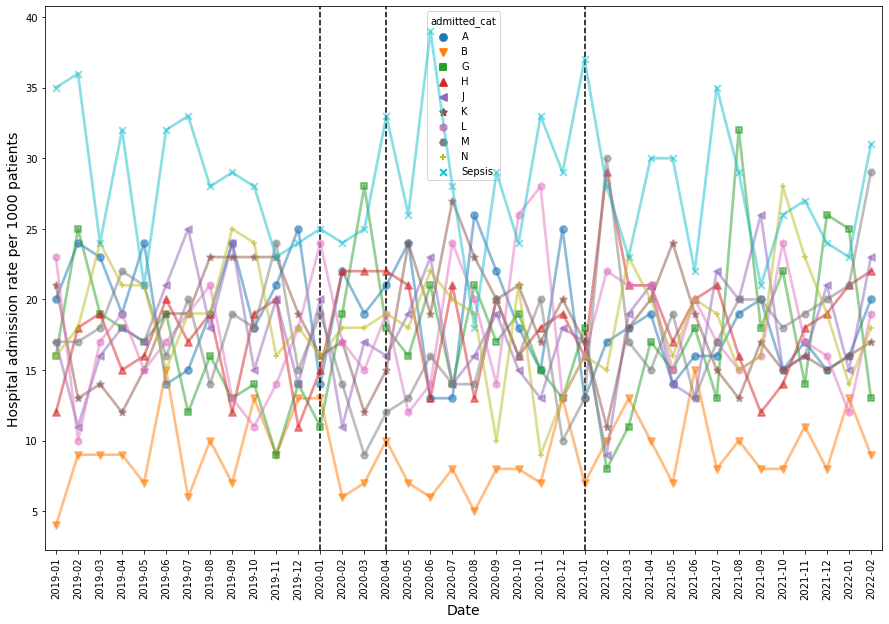

In [96]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated_ii", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

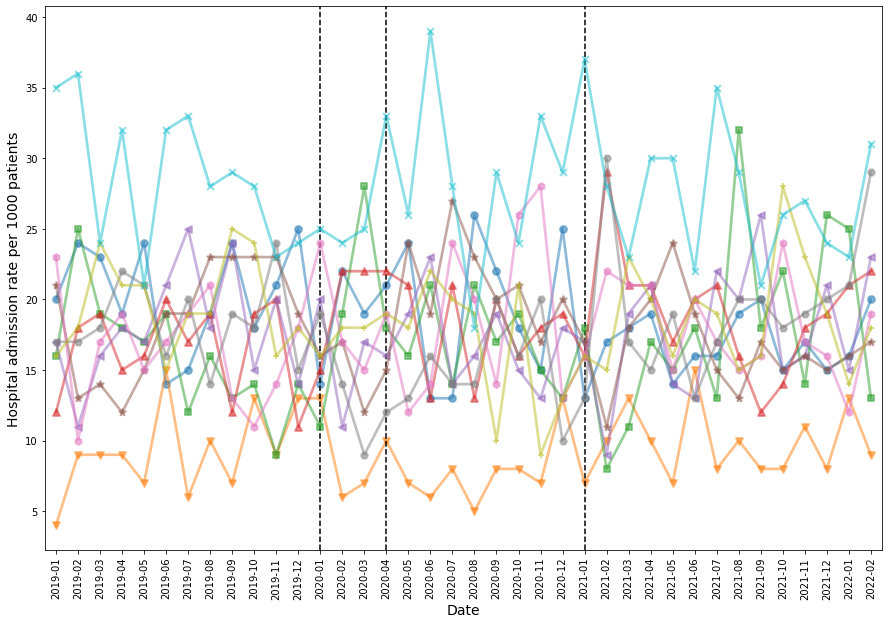

In [97]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated_ii", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission rate with GP consultation

In [60]:
data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date
0,0,292.0,500,0.584,2019-01-01
1,1,308.0,500,0.616,2019-01-01
2,0,301.0,500,0.602,2019-02-01
3,1,299.0,500,0.598,2019-02-01
4,0,306.0,500,0.612,2019-03-01
...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12-01
72,0,293.0,500,0.586,2022-01-01
73,1,307.0,500,0.614,2022-01-01
74,0,311.0,500,0.622,2022-02-01


In [61]:
data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].mean()#sum()
# data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date['value_sum'] = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum().value #data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01-01,0,0.584,0.584
1,2019-01-01,1,0.616,0.616
2,2019-02-01,0,0.602,0.602
3,2019-02-01,1,0.598,0.598
4,2019-03-01,0,0.612,0.612
...,...,...,...,...
71,2021-12-01,1,0.608,0.608
72,2022-01-01,0,0.586,0.586
73,2022-01-01,1,0.614,0.614
74,2022-02-01,0,0.622,0.622


In [64]:
data_hosp_rate_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_gp_groupby_date.date)

data_hosp_rate_gp_groupby_date.date = data_hosp_rate_gp_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_gp_groupby_date.head()

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01,0,0.584,0.584
1,2019-01,1,0.616,0.616
2,2019-02,0,0.602,0.602
3,2019-02,1,0.598,0.598
4,2019-03,0,0.612,0.612


In [65]:
data_hosp_rate_gp_groupby_date['value'] = data_hosp_rate_gp_groupby_date['value']*1000

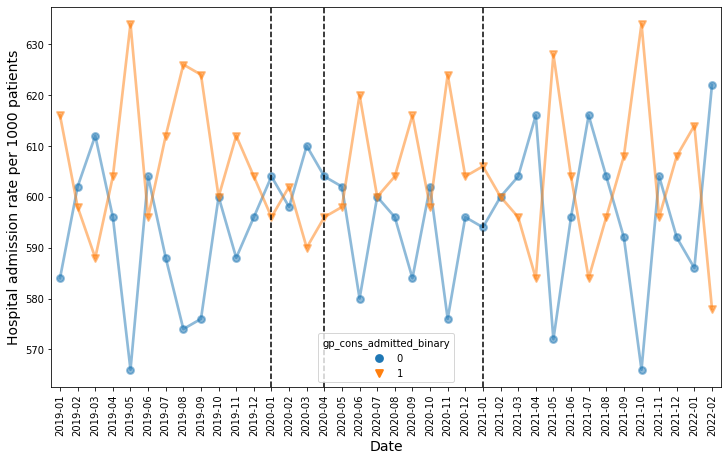

In [66]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

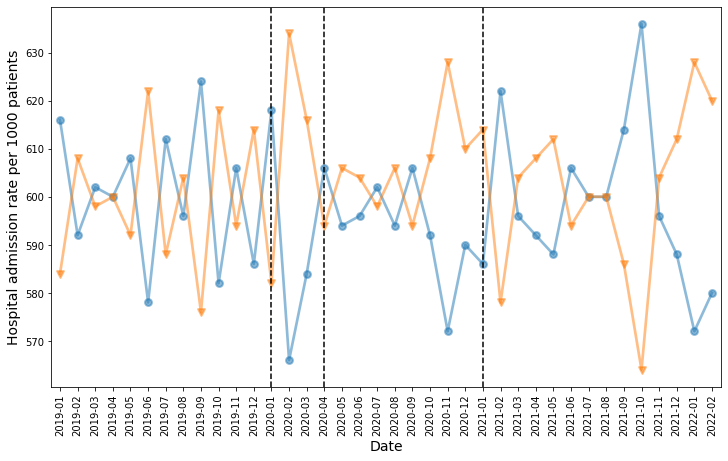

In [85]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()

In [67]:
data_hosp_rate_gp.date = pd.to_datetime(data_hosp_rate_gp.date)
data_hosp_rate_gp.date = data_hosp_rate_gp.date.dt.strftime('%Y-%m')
data_hosp_rate_gp#.head()

,gp_cons_admitted_binary,admitted_binary,population,value,date
0,0,292.0,500,0.584,2019-01
1,1,308.0,500,0.616,2019-01
2,0,301.0,500,0.602,2019-02
3,1,299.0,500,0.598,2019-02
4,0,306.0,500,0.612,2019-03
...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12
72,0,293.0,500,0.586,2022-01
73,1,307.0,500,0.614,2022-01
74,0,311.0,500,0.622,2022-02


In [68]:
data_hosp_rate_sex_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199920
1,2019-02,600.0,1000,1.199779
2,2019-03,600.0,1000,1.200131
3,2019-04,600.0,1000,1.200120
4,2019-05,600.0,1000,1.200564


In [69]:
#add population_group_by_sex to calculate percentage of hospital admission with gp cons
data_hosp_rate_gp['population_group_by_sex'] = np.nan
col_population = data_hosp_rate_gp.columns.get_loc('population_group_by_sex')
col_date = data_hosp_rate_gp.columns.get_loc('date')
col_admitted = data_hosp_rate_sex_groupby_date.columns.get_loc('admitted_binary')
col_date_sex_groupby = data_hosp_rate_sex_groupby_date.columns.get_loc('date')

for idx, x in enumerate(data_hosp_rate_gp['population_group_by_sex']):
    for idy, y in enumerate(data_hosp_rate_sex_groupby_date['admitted_binary']):
        if data_hosp_rate_sex_groupby_date.iat[idy, col_date_sex_groupby] == data_hosp_rate_gp.iat[idx, col_date]:
            data_hosp_rate_gp.iat[idx, col_population] = data_hosp_rate_sex_groupby_date.iat[idy, col_admitted]

data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date,population_group_by_sex
0,0,292.0,500,0.584,2019-01,600.0
1,1,308.0,500,0.616,2019-01,600.0
2,0,301.0,500,0.602,2019-02,600.0
3,1,299.0,500,0.598,2019-02,600.0
4,0,306.0,500,0.612,2019-03,600.0
...,...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12,600.0
72,0,293.0,500,0.586,2022-01,600.0
73,1,307.0,500,0.614,2022-01,600.0
74,0,311.0,500,0.622,2022-02,600.0


In [70]:
data_hosp_rate_gp['value_calculated_ii'] = (data_hosp_rate_gp['admitted_binary']/data_hosp_rate_gp['population_group_by_sex'])*100
data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date,population_group_by_sex,value_calculated_ii
0,0,292.0,500,0.584,2019-01,600.0,48.666667
1,1,308.0,500,0.616,2019-01,600.0,51.333333
2,0,301.0,500,0.602,2019-02,600.0,50.166667
3,1,299.0,500,0.598,2019-02,600.0,49.833333
4,0,306.0,500,0.612,2019-03,600.0,51.000000
...,...,...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12,600.0,50.666667
72,0,293.0,500,0.586,2022-01,600.0,48.833333
73,1,307.0,500,0.614,2022-01,600.0,51.166667
74,0,311.0,500,0.622,2022-02,600.0,51.833333


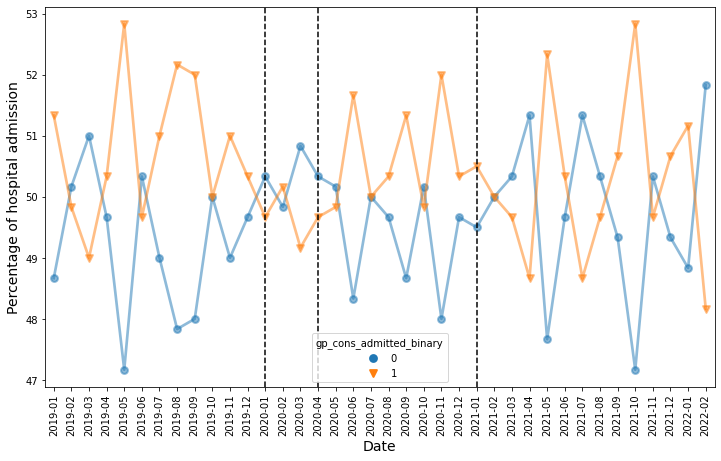

In [71]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp, y="value_calculated_ii", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_gp_couns.jpg')
plt.show()

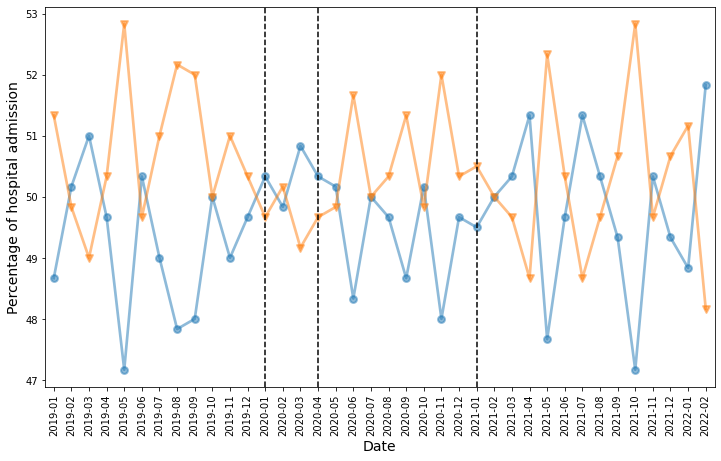

In [72]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp, y="value_calculated_ii", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=24, color='black', ls='--', lw=1.5) # "2021-01"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_gp_couns_nolegend.jpg')
plt.show()